In [1]:
%matplotlib inline
# Basic libraries ---------------
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime as dt
import sys
sys.path.append('../../parallel_programing/')
sys.path.append('../../')
import hmm_util as hmm_u
import visualization_util as vi
#import rs_hmm_learning_from_samples as rsl
import numpy as np
import math
from sklearn.externals import joblib
# End Basic libraries -----------

from sklearn.decomposition import PCA, IncrementalPCA
from matplotlib import cm, pyplot as plt, style as st, gridspec as gd
from matplotlib.dates import YearLocator, MonthLocator
st.use('seaborn-colorblind')

# Plotly library for trends:
import plotly.offline as py
import plotly.graph_objs as go  #important library for the plotly
#import cufflinks as cf
import pylab as pl
from IPython.display import display
py.init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
from plotly import tools #to do subplots

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
hmm_modelPath = '../../model/'  #Filter Data
modelFiles = os.listdir(hmm_modelPath)

In [3]:
print('Current models at', hmm_modelPath)
modelFiles

Current models at ../../model/


['hmm_CNEL EP GUAYAQUIL.pkl', 'hmm_EE. Quito.pkl']

### Selecting a model to see:

In [4]:
filenum = 1

In [5]:
model_filename = modelFiles[filenum]
model_f = model_filename.split("_")[1]
print('Get model for ', model_f)
path_open = hmm_modelPath + model_filename
print("\tReading the HMM model: \n{0}".format(path_open)) 
model = joblib.load(path_open)
n_comp = model.n_components
n_features = model.n_features

print("\tn_comp = {0}, n_features = {1}".format(n_comp,n_features))

Get model for  EE. Quito.pkl
	Reading the HMM model: 
../../model/hmm_EE. Quito.pkl
	n_comp = 57, n_features = 48


In [6]:
filDataPath = '../../data/'  #Filter Data
print('Reading data from: ' + model_f)
df = pd.read_pickle(filDataPath + model_f)
for col in df.columns:
    #df[col] = df[col].interpolate(method='from_derivatives')
    df[col] = df[col].interpolate(method='nearest',limit=3, limit_direction='both')
        
#df.fillna(-1,inplace=True)
    #print(df_x.info())    
if len(df.columns) < 24:
    df_x = hmm_u.pivot_DF_using_dates_and_hours(df)
else:
    df_x = df.copy()
X = df_x.values
#iCol, iRow = rs.set_iCol_and_iRow(iCol, iRow, nrows, ncols

Reading data from: EE. Quito.pkl


In [7]:
start_p = np.array([1 / n_comp for i in range(n_comp)])
model.startprob_ = start_p
print("From " + df_x.index[0] + " to " + df_x.index[-1] )
print("Number of samples to observe: ", len(X))
hidden_states = model.predict(X)
print("\tInfering the hidden states from the observed samples. A sequence of {0} hidden status were infered".format(len(hidden_states)))
df_y = pd.DataFrame(hidden_states, columns=['hidden_states'])
df_y.index = df_x.index

From 2014-01-01 to 2018-04-15
Number of samples to observe:  1552
	Infering the hidden states from the observed samples. A sequence of 1552 hidden status were infered


In [8]:
#lol = df["TEMPERATURA (ºC)"].min()
lol = df.quantile(0.02)
lol = np.amin(lol)
#upl = df["TEMPERATURA (ºC)"].max()
upl = df.quantile(0.98)
upl = np.amax(upl)
# upl = 900
print("Defining limits to plot (min:{0} ,max: {1})".format(lol,upl))

Defining limits to plot (min:308.4334 ,max: 746.005)


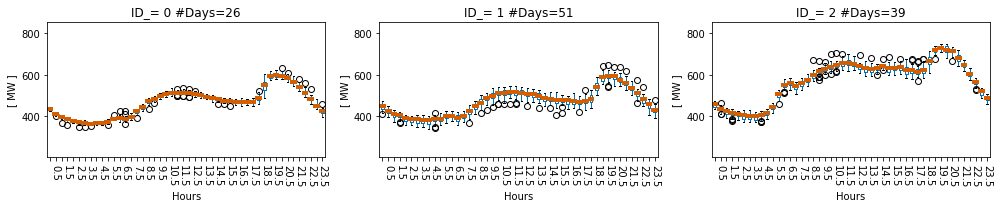

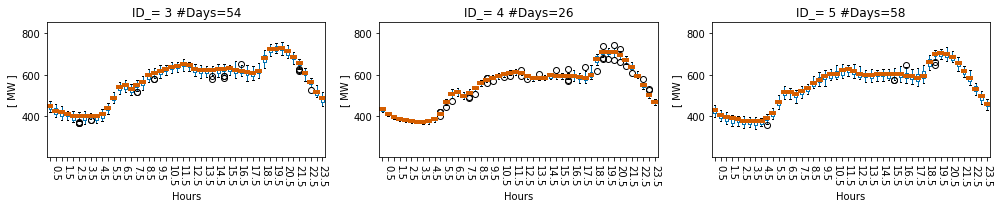

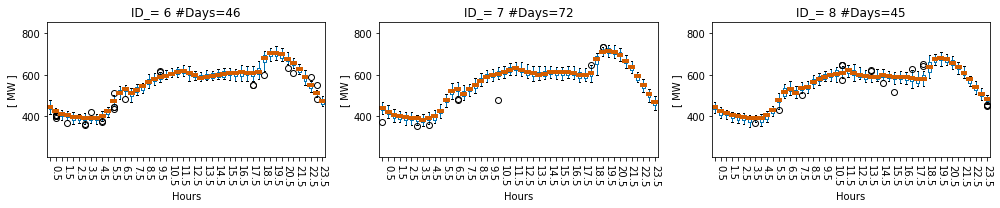

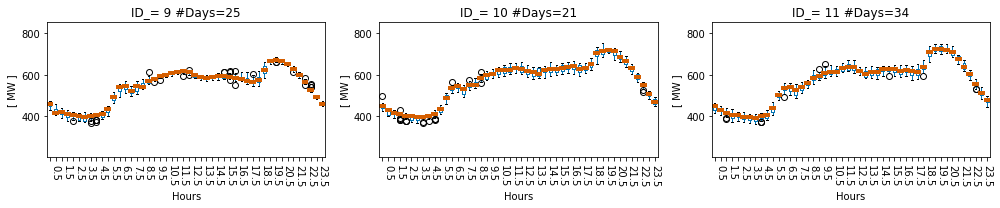

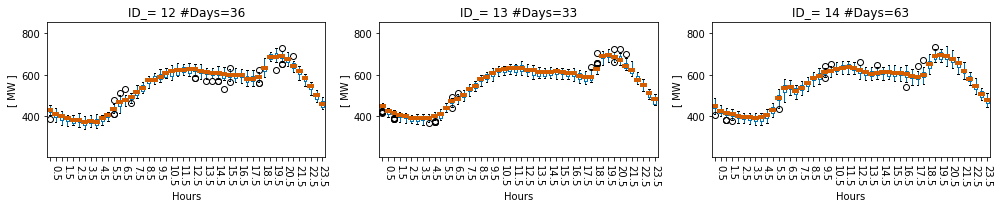

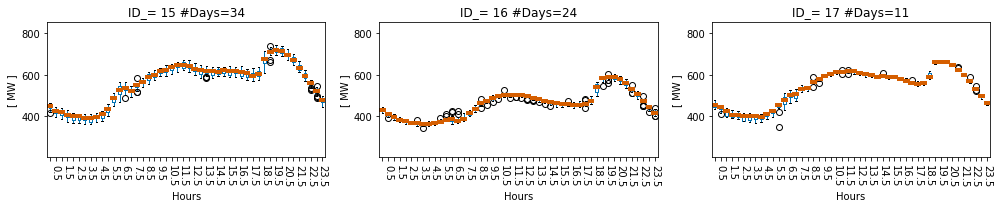

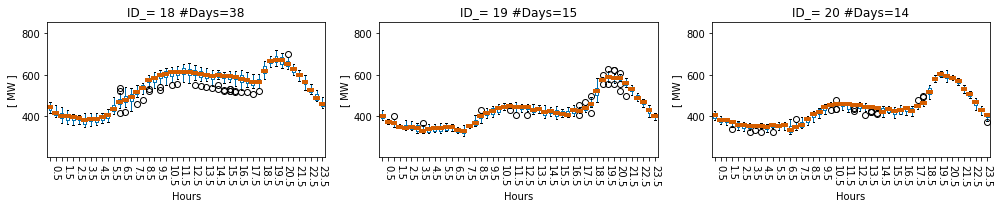

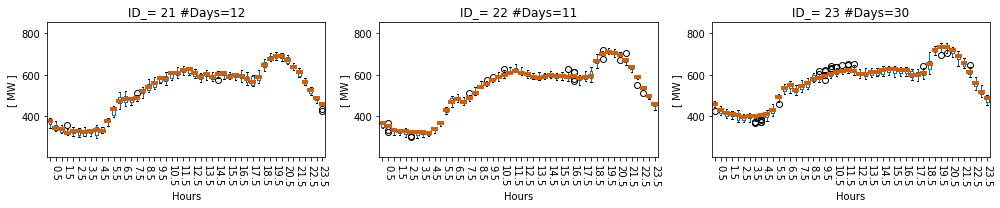

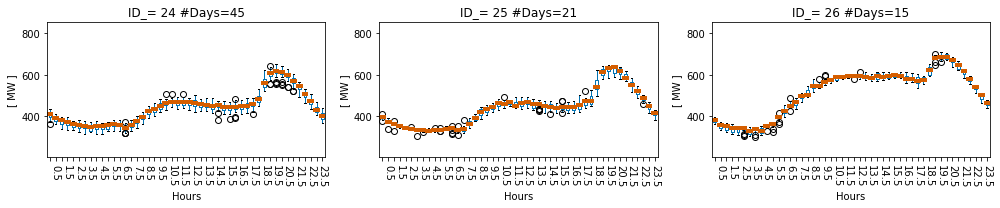

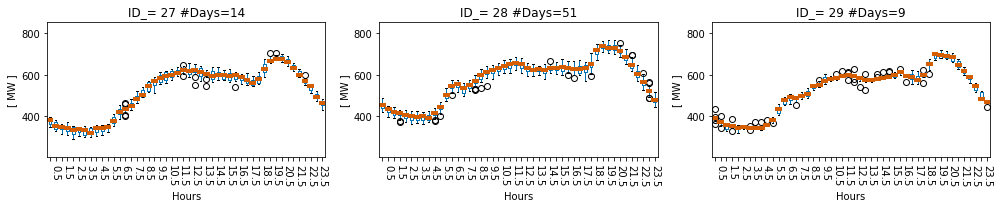

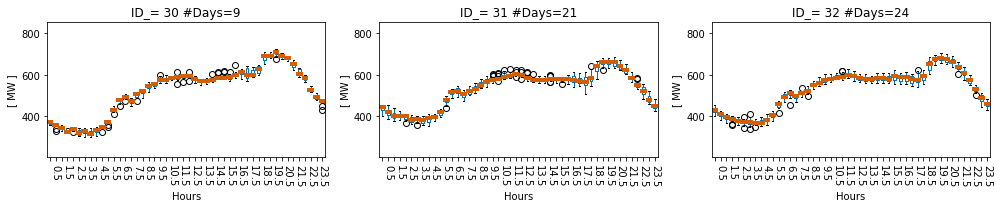

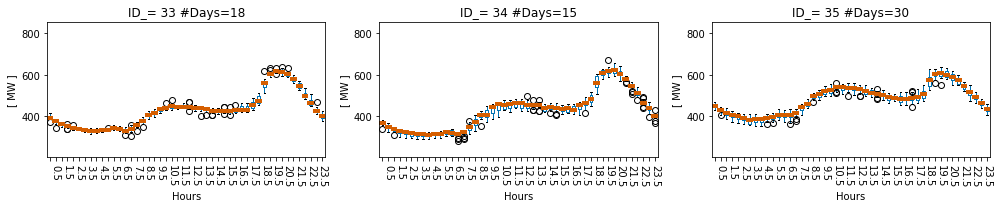

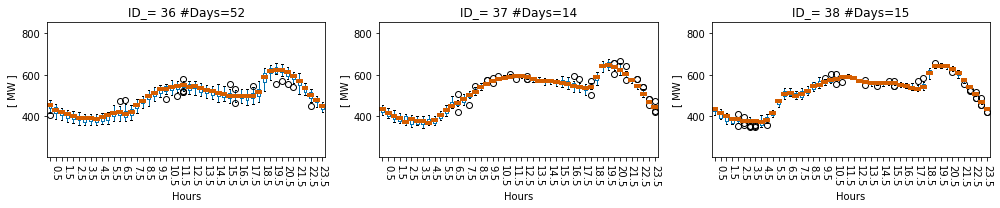

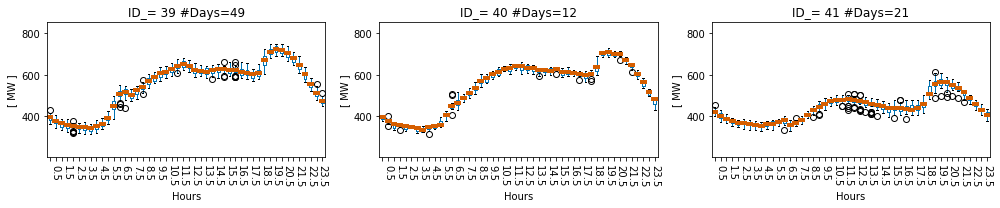

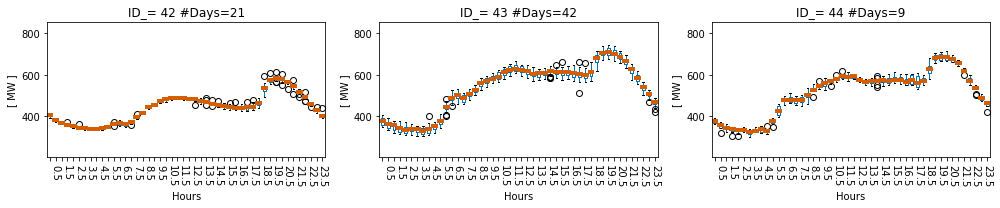

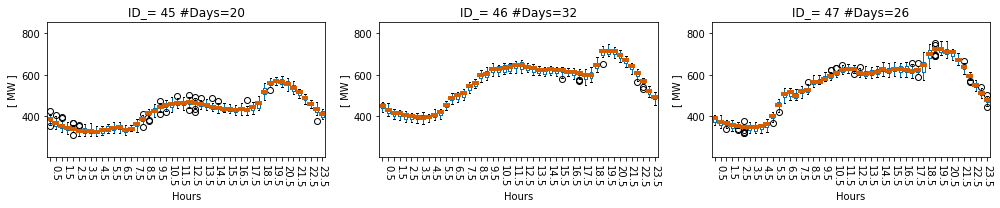

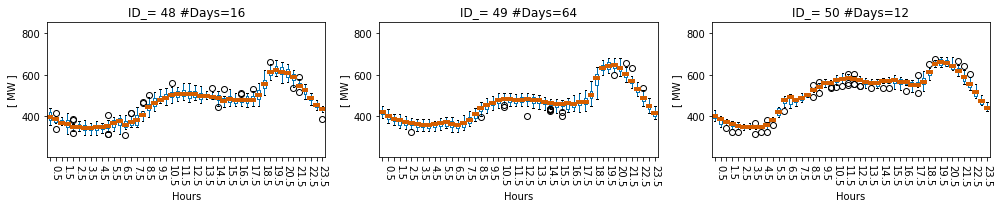

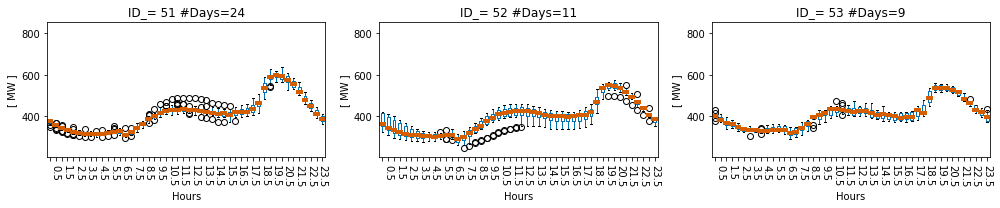

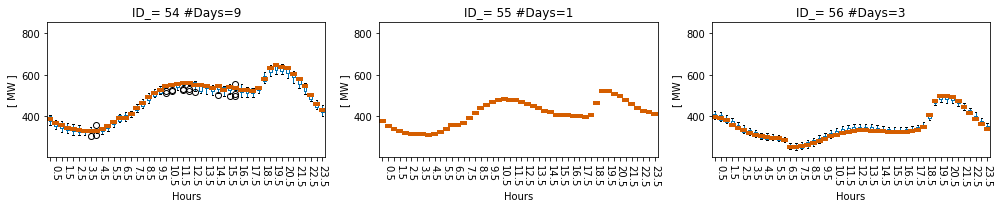

In [9]:
dv = (upl - lol) * 0.2
yLim = [lol-1.2*dv, upl+1.2*dv]
#yLim = [400, 900] 
n_col = 4
units = "MW"

figures = vi.plot_profiles_24h(df_x, df_y, states_to_plot=range(n_comp),yLim=yLim,units=units, n_col=3, figsize=(14,3))

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [11]:
M = list() 
for n in range(model.n_components):
    M.append(model.means_[n])
X = np.array(M)
    
methods = ['average', 'single', 'complete', 'median', 'ward', 'weighted'] 
# 'centroid' is not included because it causes a more difficult interpretation of the Dendrogram
metrics = ['euclidean', 'minkowski', 'cityblock', 'sqeuclidean']

#Z_f = dict()
print('\nSearching the best linkage method and distance metric for hierchical clustering of candidates - model:', model_f)
print(X.shape)

df_table = pd.DataFrame(index=methods,columns=metrics)
s_method, s_metric, c_max = '','',-1 
for method in methods:
    for metric in metrics:
        try:
            Z = linkage(X, method=method ,metric=metric)
            c, coph_dists = cophenet(Z, pdist(X))
        except:
            c = np.nan
        df_table[metric][method] = c
        if c > c_max:
            c_max = c
            s_method = method
            s_metric = metric
print(df_table)
Z_f = linkage(X, method='average' ,metric=s_metric)
print('\n \t--->The best method is {0} with metric {1}'.format(s_method,s_metric))


Searching the best linkage method and distance metric for hierchical clustering of candidates - model: EE. Quito.pkl
(57, 48)
         euclidean minkowski cityblock sqeuclidean
average   0.856326  0.856326  0.855485    0.851576
single    0.869604  0.869604  0.872675    0.828991
complete  0.849985  0.849985  0.851746    0.842485
median    0.872385       NaN       NaN         NaN
ward      0.841004       NaN       NaN         NaN
weighted  0.878507  0.878507  0.857217    0.842425

 	--->The best method is weighted with metric euclidean


### Hierarchical Clustering Dendogram

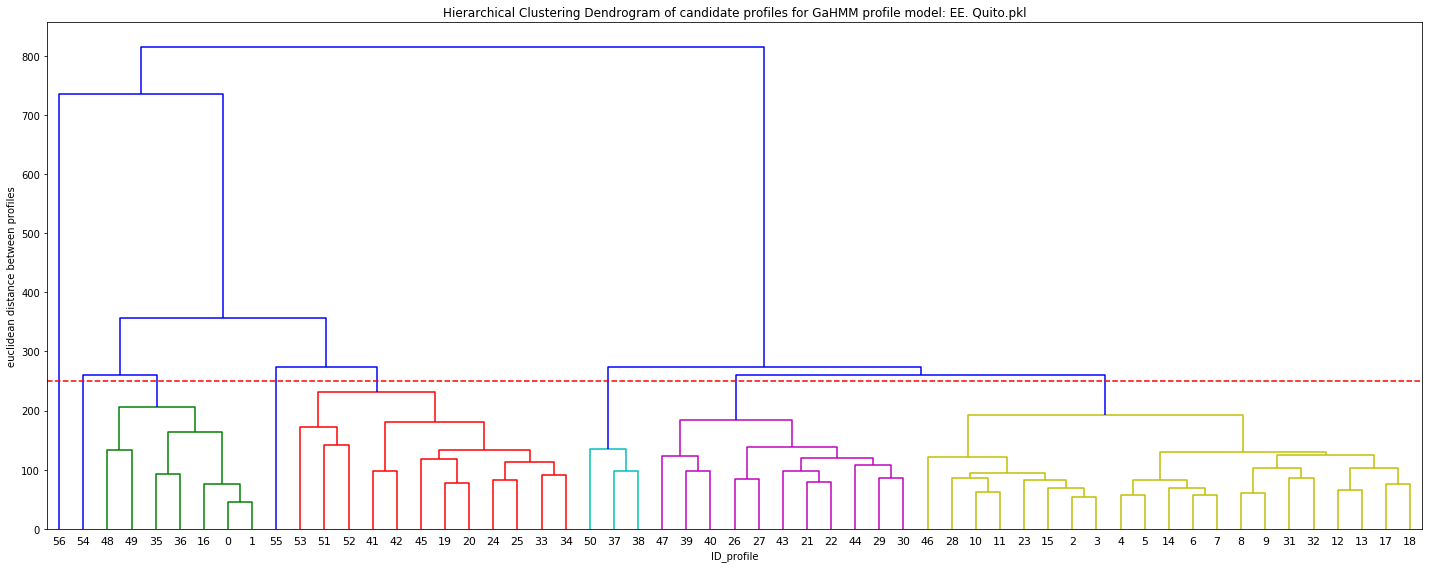

In [12]:
R = dict()
threshold = 250
# calculate full dendrogram

figHC = plt.figure(figsize=(20, 8))
plt.title('Hierarchical Clustering Dendrogram of candidate profiles for GaHMM profile model: ' + model_f)
plt.xlabel('ID_profile')
plt.ylabel('euclidean distance between profiles')
R = dendrogram(
    Z_f,
    #truncate_mode='lastp',  # show only the last p merged clusters
    #p=12,  # show only the last p merged clusters
    #show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=11.,  # font size for the x axis labels
    color_threshold=threshold,
    count_sort = 'ascending'
)
plt.plot([threshold]*1000,linestyle ='--', color='red')
plt.tight_layout()
plt.show()

In [13]:
print("Saving figures as a PDF file: ")
import matplotlib.backends.backend_pdf

path_to_save = "output/" + model_f.replace('.pkl','')
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
    
path_to_save += "/" + model_f.replace('pkl','pdf')

pdf = matplotlib.backends.backend_pdf.PdfPages(path_to_save)
figures.append(figHC)
for fig in figures: #xrange(1, figure().number): ## will open an empty extra figure :(
    pdf.savefig(fig)
pdf.close()

Saving figures as a PDF file: 


### Depuring data, exclude no-typical clusters:

In [14]:

# Exclude a particular day:
dates_to_exclude = ['2016-04-04', '2015-10-05', '2017-06-05', '2015-08-26']
exclude_dates = False
if exclude_dates is True:
    df_x.drop(dates_to_exclude, inplace=True)
    df_y.drop(dates_to_exclude, inplace=True)

# Exclude a cluster: 
# if nothing to exclude then put -1
to_exclude = [-1]
mask = df_y["hidden_states"].isin(to_exclude)
mask2 = ~mask

print("Saving depured data, excluding clusters: " + str(to_exclude))
if len(df_x[mask].index) > 0:
    df_x[mask].T.plot(legend=False)
else:
    print("There is nothing to exclude")
print(df_x[mask].index)

Saving depured data, excluding clusters: [-1]
There is nothing to exclude
Index([], dtype='object', name='date')


#### Saving depured data at:

Depured data to be saved in: ./output/EE. Quito/EE. Quito.pkl_dp


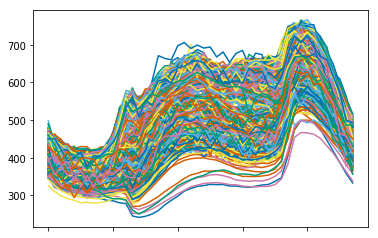

In [15]:
save_file = "./output/" + model_f.replace(".pkl","/") + model_f + "_dp"
print("Depured data to be saved in: " + save_file)
df_x[mask2].to_pickle(save_file)
df_x[mask2].T.plot(legend=False)

#### Explore a particular cluster:

Explore a particular cluster
Index(['2014-01-03', '2014-12-29', '2014-12-30', '2015-07-06', '2015-12-28',
       '2015-12-29', '2016-12-27', '2016-12-28', '2016-12-29'],
      dtype='object', name='date')


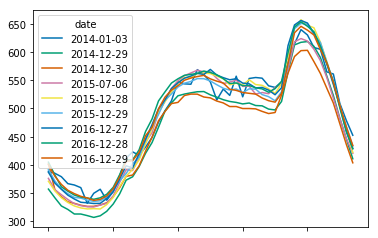

In [16]:
print("Explore a particular cluster")
to_exclude = [54]
mask = df_y["hidden_states"].isin(to_exclude)
df_x.loc[mask].T.plot(legend=True)
print(df_x[mask].index)

## Creating files for thetraining of the ANN

In [17]:
list_cl_motif = [1]

In [18]:
#df_y

In [19]:
name_columns = ["d" + str(x/2) for x in range(48)]
df_c = df_x.copy()
df_c.columns = name_columns

In [20]:
df_20to23 = df_c.iloc[:,41:48]
#df_20to23["y"] = df_y["hidden_states"]
df_20to23 = df_20to23[:-1]
df_20to23.index = pd.to_datetime(df_20to23.index)
df_20to23.index = df_20to23.index + pd.DateOffset(1)
df_20to23.index = [x._date_repr for x in df_20to23.index]
#df_20to23.to_excel("20.5to23.xls")

In [21]:
df_0to4 = df_c.iloc[:,0:10]
df_0to4 = df_0to4[1:]
result = pd.concat([df_20to23, df_0to4], axis=1)
result.loc[:,"y"] = df_y["hidden_states"]
output_path = "./output/" + model_f.replace(".pkl","/")
result.to_excel( output_path + "N1.xls")
#df_0to4.to_excel("0to4.5.xls")

In [22]:
result = df_x.iloc[:,0:17]
result.loc[:,"y"] = df_y["hidden_states"]
result.to_excel(output_path + "N2.xls")
#df_0to4.to_excel("0to4.5.xls")

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:621: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [23]:
df_0to15 = df_x.iloc[:,0:31]
df_0to15.loc[:,"y"] = df_y["hidden_states"]
df_0to15.to_excel(output_path + "N3.xls")

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:621: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

